<a href="https://colab.research.google.com/github/govher-s/CSC492_labs/blob/main/01_your_first_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 1: Your First Neural Network

## A Hands-On Journey Through Deep Learning

Welcome! In this series of three notebooks, you'll build neural networks from scratch and develop deep intuition for how they learn. We'll follow two real projects throughout:

- **California Housing** — predicting house prices (regression)
- **MNIST Digits** — recognizing handwritten digits (classification)

In this first notebook, you'll:
1. Load and prepare real data for training
2. Build your first neural network (a single neuron!)
3. Train it to predict house prices
4. Understand *how* neural networks learn via gradient descent and backpropagation

### Prerequisites
- Basic Python programming
- Linear algebra fundamentals (vectors, matrices)
- Calculus basics (derivatives, chain rule)

Let's dive in!

In [ ]:
# Core deep learning framework
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Numerical and data processing
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 12

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.10.0


In [ ]:
# Device configuration - use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else
                      'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: mps


---
# Module 1: Your First Neural Network

**Goal**: Build a complete neural network that predicts California house prices — in just a few cells!

We'll follow the deep learning pipeline end-to-end:

```
Load Data → Prepare Data → Build Model → Define Loss → Train → Evaluate
```

Let's start with the data.

In [ ]:
# Load California Housing dataset
housing = fetch_california_housing()
X_housing = housing.data
y_housing = housing.target

print("Dataset shape:", X_housing.shape)
print("Target shape:", y_housing.shape)
print(f"\nWe have {X_housing.shape[0]:,} houses with {X_housing.shape[1]} features each.")
print(f"Target: Median house value (in $100,000s)")
print("\nFeature names:", housing.feature_names)
print("\nSample house (first row):")
for name, val in zip(housing.feature_names, X_housing[0]):
    print(f"  {name}: {val:.4f}")
print(f"\n  Price: ${y_housing[0] * 100000:,.0f}")

Dataset shape: (20640, 8)
Target shape: (20640,)

We have 20,640 houses with 8 features each.
Target: Median house value (in $100,000s)

Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']

Sample house (first row):
  MedInc: 8.3252
  HouseAge: 41.0000
  AveRooms: 6.9841
  AveBedrms: 1.0238
  Population: 322.0000
  AveOccup: 2.5556
  Latitude: 37.8800
  Longitude: -122.2300

  Price: $452,600


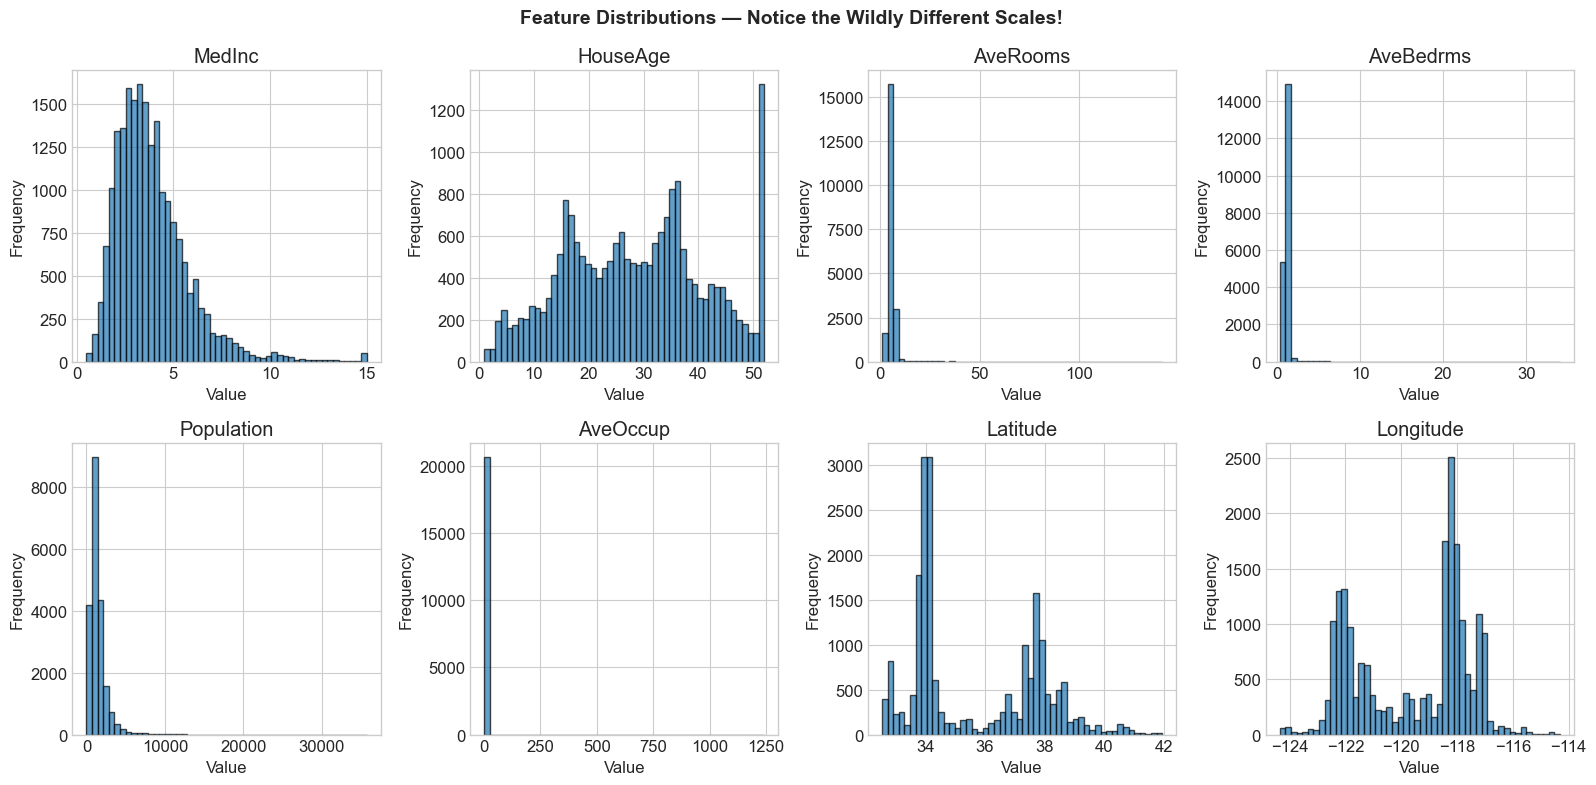

Problem: MedInc ranges from 0-15, while Population ranges from 3-35,000!
Neural networks struggle when features are on very different scales.


In [ ]:
# Let's look at what we're working with
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, (ax, name) in enumerate(zip(axes, housing.feature_names)):
    ax.hist(X_housing[:, idx], bins=50, edgecolor='black', alpha=0.7)
    ax.set_title(name)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.suptitle('Feature Distributions — Notice the Wildly Different Scales!',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Problem: MedInc ranges from 0-15, while Population ranges from 3-35,000!")
print("Neural networks struggle when features are on very different scales.")

### Why Standardization Matters

Look at those histograms — `MedInc` ranges from 0 to 15, but `Population` goes up to 35,000! When features are on wildly different scales, gradient descent takes a zigzag path instead of heading straight to the minimum.

**Standardization** transforms each feature to have mean = 0 and standard deviation = 1:

$$z = \frac{x - \mu}{\sigma}$$

This puts all features on the same playing field.

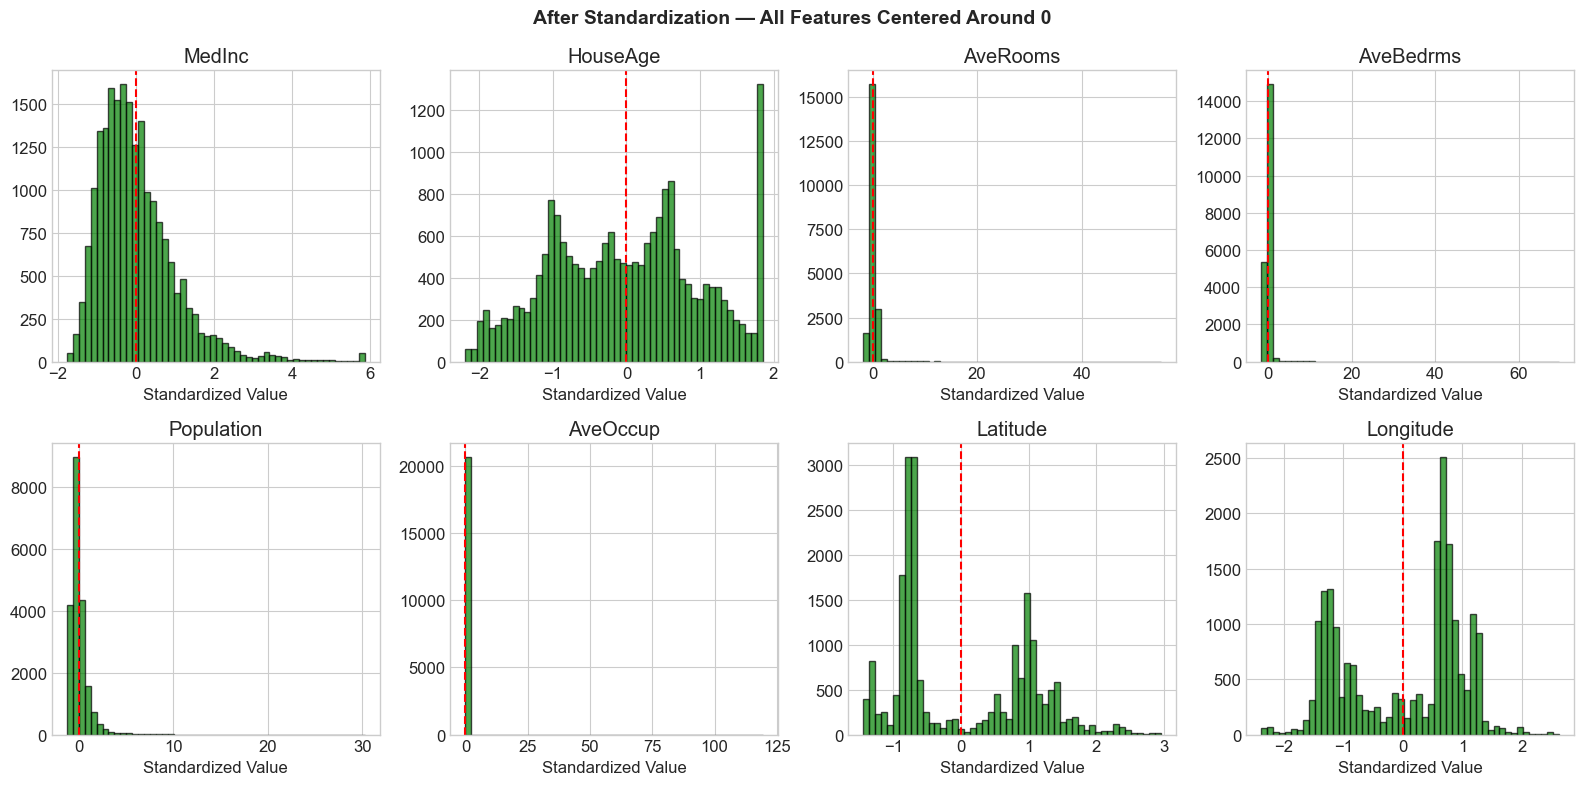

After standardization:
  Mean of MedInc: 0.000000 (was 3.87)
  Std of MedInc:  1.000000


In [ ]:
# Visualize what standardization does (conceptual demo on full dataset)
scaler_demo = StandardScaler()
X_demo_scaled = scaler_demo.fit_transform(X_housing)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, (ax, name) in enumerate(zip(axes, housing.feature_names)):
    ax.hist(X_demo_scaled[:, idx], bins=50, edgecolor='black', alpha=0.7, color='green')
    ax.set_title(name)
    ax.axvline(x=0, color='red', linestyle='--', label='mean=0')
    ax.set_xlabel('Standardized Value')

plt.suptitle('After Standardization — All Features Centered Around 0',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"After standardization:")
print(f"  Mean of MedInc: {X_demo_scaled[:, 0].mean():.6f} (was {X_housing[:, 0].mean():.2f})")
print(f"  Std of MedInc:  {X_demo_scaled[:, 0].std():.6f}")

### Train / Validation / Test Splits

Before training, we split our data into three sets:

| Set | Purpose | Analogy |
|-----|---------|--------|
| **Training** (70%) | Model learns from this | Studying textbook |
| **Validation** (15%) | Tune hyperparameters | Practice exam |
| **Test** (15%) | Final evaluation | Final exam |

**Why three sets?** If we tune our model based on test performance, we're "cheating" — the test set should only be used once, at the very end.

In [ ]:
# Custom PyTorch Dataset
class HousingDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Split FIRST, then standardize (to avoid data leakage)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_housing, y_housing, test_size=0.15, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42  # 0.176 * 0.85 ≈ 0.15
)

# Fit scaler on TRAINING data only, then transform all sets
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   # fit + transform on train
X_val = scaler.transform(X_val)           # transform only on val
X_test = scaler.transform(X_test)         # transform only on test

# Create datasets and DataLoaders
train_dataset = HousingDataset(X_train, y_train)
val_dataset = HousingDataset(X_val, y_val)
test_dataset = HousingDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training samples:   {len(train_dataset):,}")
print(f"Validation samples: {len(val_dataset):,}")
print(f"Test samples:       {len(test_dataset):,}")
print(f"\nBatches per epoch:  {len(train_loader)}")
print(f"\nNote: Scaler fit on training data only (no data leakage!)")

Training samples:   14,456
Validation samples: 3,088
Test samples:       3,096

Batches per epoch:  226

Note: Scaler fit on training data only (no data leakage!)


### The Perceptron — A Single Neuron

The simplest neural network is a **perceptron** — just one neuron. It takes input features, multiplies each by a weight, adds a bias, and produces a single output:

```
  x₁ ──w₁──┐
            │
  x₂ ──w₂──┼──► Σ + b ──► output (predicted price)
            │
  x₃ ──w₃──┘
```

**Formula**: $\hat{y} = w_1 x_1 + w_2 x_2 + \cdots + w_n x_n + b = \mathbf{w}^T \mathbf{x} + b$

This is just linear regression! Let's see if a single neuron can predict house prices.

In [ ]:
class Perceptron(nn.Module):
    """A single neuron — the simplest possible neural network."""

    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, 1)  # weights + bias

    def forward(self, x):
        return self.linear(x)

# Create our first model!
model = Perceptron(input_size=8)  # 8 housing features
model = model.to(device)

# Let's peek inside
print("Our first neural network:")
print(f"  Parameters: {sum(p.numel() for p in model.parameters())} total")
print(f"  Weights shape: {model.linear.weight.shape}  (one weight per feature)")
print(f"  Bias shape: {model.linear.bias.shape}")
print(f"\nInitial (random) weights:")
for name, val in zip(housing.feature_names, model.linear.weight.data[0].cpu()):
    print(f"  {name}: {val:.4f}")

Our first neural network:
  Parameters: 9 total
  Weights shape: torch.Size([1, 8])  (one weight per feature)
  Bias shape: torch.Size([1])

Initial (random) weights:
  MedInc: 0.2703
  HouseAge: 0.2935
  AveRooms: -0.0828
  AveBedrms: 0.3248
  Population: -0.0775
  AveOccup: 0.0713
  Latitude: -0.1721
  Longitude: 0.2076


### Training — How Does a Network Learn?

Training is a loop:
1. **Forward pass**: Feed data through the model to get predictions
2. **Compute loss**: Measure how wrong the predictions are (we'll use Mean Squared Error)
3. **Backward pass**: Compute gradients — which direction to adjust each weight
4. **Update weights**: Nudge weights in the direction that reduces the loss

$$\text{MSE} = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$

Let's see this in action!

In [4]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
train_losses = []
val_losses = []

print("Training our first neural network!\n")

for epoch in range(50):
    # --- Training ---
    model.train()
    epoch_train_loss = 0.0
    n_train = 0

    for features, targets in train_loader:
        features, targets = features.to(device), targets.to(device)

        optimizer.zero_grad()          # Reset gradients
        predictions = model(features)  # Forward pass
        loss = criterion(predictions, targets)  # Compute loss
        loss.backward()                # Backward pass (compute gradients)
        optimizer.step()               # Update weights

        epoch_train_loss += loss.item() * features.size(0)
        n_train += features.size(0)

    train_losses.append(epoch_train_loss / n_train)

    # --- Validation ---
    model.eval()
    epoch_val_loss = 0.0
    n_val = 0

    with torch.no_grad():
        for features, targets in val_loader:
            features, targets = features.to(device), targets.to(device)
            predictions = model(features)
            loss = criterion(predictions, targets)
            epoch_val_loss += loss.item() * features.size(0)
            n_val += features.size(0)

    val_losses.append(epoch_val_loss / n_val)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d}/50  |  Train Loss: {train_losses[-1]:.4f}  |  Val Loss: {val_losses[-1]:.4f}")

print("\nDone! The loss went down — our neuron is learning!")

NameError: name 'nn' is not defined

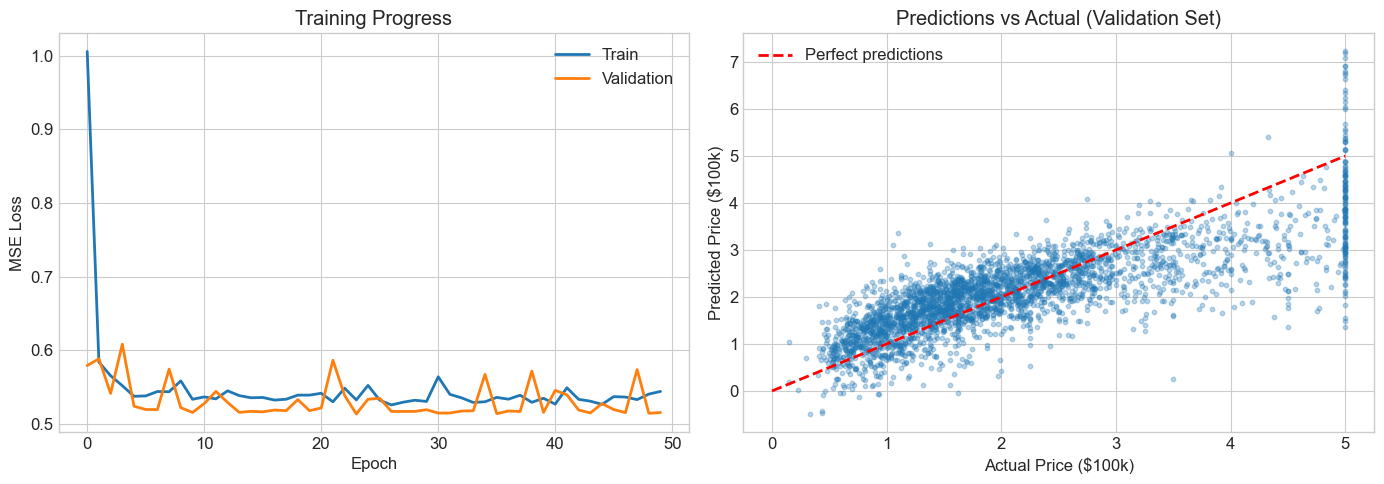

Final validation MSE: 0.5158
RMSE: ~$71,821 (a typical prediction error).


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(train_losses, label='Train', linewidth=2)
axes[0].plot(val_losses, label='Validation', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training Progress')
axes[0].legend()

# Predictions vs Actual on validation set
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for features, targets in val_loader:
        features = features.to(device)
        preds = model(features).cpu()
        all_preds.append(preds)
        all_targets.append(targets)

all_preds = torch.cat(all_preds).numpy().flatten()
all_targets = torch.cat(all_targets).numpy().flatten()

axes[1].scatter(all_targets, all_preds, alpha=0.3, s=10)
axes[1].plot([0, 5], [0, 5], 'r--', linewidth=2, label='Perfect predictions')
axes[1].set_xlabel('Actual Price ($100k)')
axes[1].set_ylabel('Predicted Price ($100k)')
axes[1].set_title('Predictions vs Actual (Validation Set)')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Final validation MSE: {val_losses[-1]:.4f}")
print(f"RMSE: ~${np.sqrt(val_losses[-1]) * 100000:,.0f} (a typical prediction error).")

### Evaluating Our Model

Our model has been trained and tuned using training and validation data. Now let's see how it performs on the **test set** — data it has never seen before.

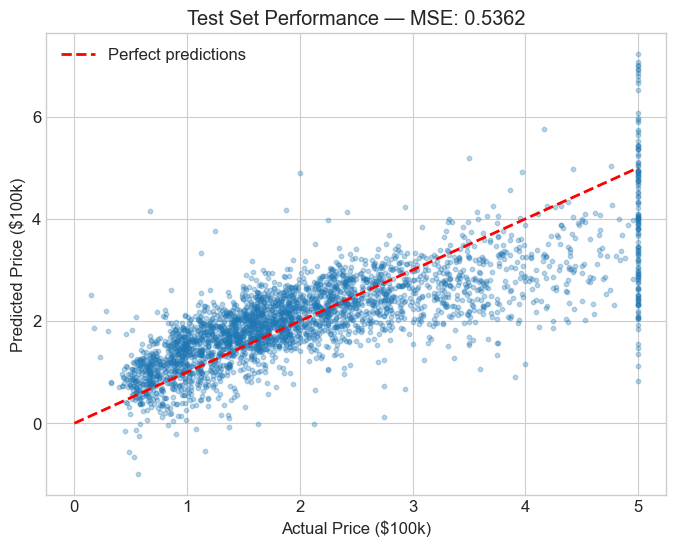

Test MSE: 0.5362
RMSE: ~$73,225 (a typical prediction error)

Not bad for a single neuron! But can we do better?
(Spoiler: yes — we'll build a deeper network in Notebook 2)


In [ ]:
# Evaluate on test set
model.eval()
test_preds = []
test_targets = []

with torch.no_grad():
    for features, targets in test_loader:
        features = features.to(device)
        preds = model(features).cpu()
        test_preds.append(preds)
        test_targets.append(targets)

test_preds = torch.cat(test_preds).numpy().flatten()
test_targets = torch.cat(test_targets).numpy().flatten()

test_mse = np.mean((test_preds - test_targets) ** 2)

plt.figure(figsize=(8, 6))
plt.scatter(test_targets, test_preds, alpha=0.3, s=10)
plt.plot([0, 5], [0, 5], 'r--', linewidth=2, label='Perfect predictions')
plt.xlabel('Actual Price ($100k)')
plt.ylabel('Predicted Price ($100k)')
plt.title(f'Test Set Performance — MSE: {test_mse:.4f}')
plt.legend()
plt.show()

print(f"Test MSE: {test_mse:.4f}")
print(f"RMSE: ~${np.sqrt(test_mse) * 100000:,.0f} (a typical prediction error)")
print(f"\nNot bad for a single neuron! But can we do better?")
print(f"(Spoiler: yes — we'll build a deeper network in Notebook 2)")

### Guided Exercise: What If We Skip Standardization?

**Hypothesis**: Before running the experiment, write down your prediction:
> *"If we train the same perceptron on UN-standardized data (raw features), the model will _____ because _____."*

**Experiment**: Run the cell below, which trains the same model on raw (unscaled) data.

**Interpret**: Compare the loss curves. Was your hypothesis correct? Why does standardization matter so much?

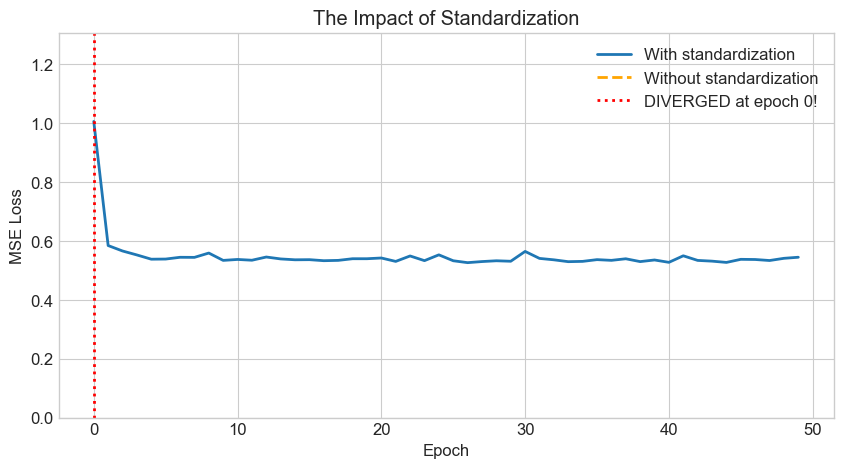

With standardization:    Final loss = 0.5444
Without standardization: DIVERGED (loss became infinite)!

The model exploded! With raw features (Population up to 35,000),
gradients become enormous and weights shoot to infinity.

Interpretation: Without standardization, features on wildly different scales
create an elongated loss landscape. Gradient descent either diverges entirely
or takes a painfully zigzag path. Standardization is essential!


In [ ]:
# EXPERIMENT: Training WITHOUT standardization
torch.manual_seed(42)

# Split the RAW (unscaled) data using the SAME random_state to get identical rows
X_temp_raw, _, y_temp_raw, _ = train_test_split(
    X_housing, y_housing, test_size=0.15, random_state=42
)
X_train_raw, _, y_train_raw, _ = train_test_split(
    X_temp_raw, y_temp_raw, test_size=0.176, random_state=42
)

raw_train_dataset = HousingDataset(X_train_raw, y_train_raw)
raw_train_loader = DataLoader(raw_train_dataset, batch_size=64, shuffle=True)

# Same model architecture and learning rate
raw_model = Perceptron(input_size=8).to(device)
raw_criterion = nn.MSELoss()
raw_optimizer = optim.SGD(raw_model.parameters(), lr=0.01)

# Train
raw_losses = []
for epoch in range(50):
    raw_model.train()
    epoch_loss = 0.0
    n = 0
    for features, targets in raw_train_loader:
        features, targets = features.to(device), targets.to(device)
        raw_optimizer.zero_grad()
        loss = raw_criterion(raw_model(features), targets)
        loss.backward()
        raw_optimizer.step()
        epoch_loss += loss.item() * features.size(0)
        n += features.size(0)
    raw_losses.append(epoch_loss / n)

# Compare
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(train_losses, label='With standardization', linewidth=2)

# Check if raw model diverged (NaN/Inf losses)
raw_finite = [l for l in raw_losses if np.isfinite(l)]
if len(raw_finite) < len(raw_losses):
    diverge_epoch = next(i for i, l in enumerate(raw_losses) if not np.isfinite(l))
    ax.plot(range(diverge_epoch), raw_losses[:diverge_epoch], '--', linewidth=2,
            color='orange', label='Without standardization')
    ax.axvline(x=diverge_epoch, color='red', linestyle=':', linewidth=2,
               label=f'DIVERGED at epoch {diverge_epoch}!')
    y_max = max(max(train_losses), max(raw_losses[:diverge_epoch]) if diverge_epoch > 0 else train_losses[0]) * 1.3
else:
    ax.plot(raw_losses, label='Without standardization', linewidth=2, linestyle='--')
    y_max = max(max(raw_losses), max(train_losses)) * 1.1

ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.set_title('The Impact of Standardization')
ax.legend()
ax.set_ylim(0, y_max)
plt.show()

print(f"With standardization:    Final loss = {train_losses[-1]:.4f}")
if len(raw_finite) < len(raw_losses):
    print(f"Without standardization: DIVERGED (loss became infinite)!")
    print(f"\nThe model exploded! With raw features (Population up to 35,000),")
    print(f"gradients become enormous and weights shoot to infinity.")
else:
    print(f"Without standardization: Final loss = {raw_losses[-1]:.4f}")

print(f"\nInterpretation: Without standardization, features on wildly different scales")
print(f"create an elongated loss landscape. Gradient descent either diverges entirely")
print(f"or takes a painfully zigzag path. Standardization is essential!")

### Module 1 Summary

Congratulations — you just built, trained, and evaluated your first neural network!

Here's what we covered:
- **Data**: Loaded California Housing, standardized features, created train/val/test splits
- **Model**: Built a Perceptron (single neuron = linear regression)
- **Loss**: Used MSE to measure prediction error
- **Optimizer**: SGD nudged weights to reduce the loss each epoch
- **Evaluation**: Tested on held-out data

But there's a mystery: *what exactly happened inside `loss.backward()` and `optimizer.step()`?* Let's find out.

---
# Module 2: How Neural Networks Learn

In Module 1, we wrote `loss.backward()` and `optimizer.step()` — and the model magically improved. But what actually happened?

In this module, we'll visualize:
1. The **loss surface** — the landscape our optimizer navigates
2. **Gradient descent** — walking downhill to find the minimum
3. **Learning rate** — how big are your steps?
4. **Backpropagation** — how PyTorch computes gradients automatically

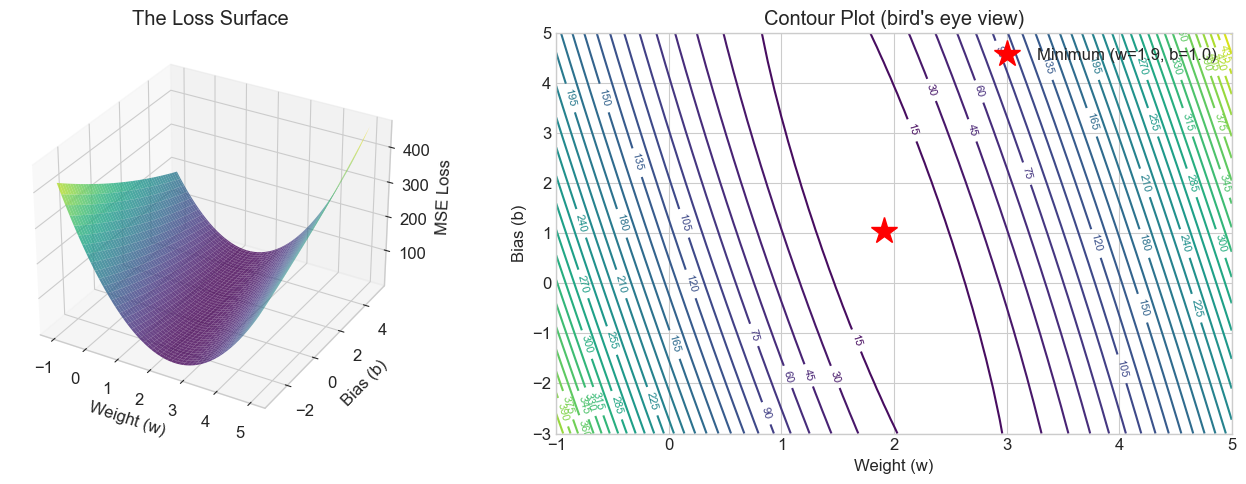

The loss surface is a bowl! The minimum is at w=1.91, b=1.04.
(The generating parameters were w=2, b=1; noise shifts the minimum slightly.)
Gradient descent 'rolls downhill' on this surface to find the minimum.


In [ ]:
# Let's visualize what the optimizer "sees"
# Simple model: y = w*x + b (just 2 parameters, so we can plot the surface)

np.random.seed(42)
X_simple = np.linspace(0, 10, 50)
y_simple = 2 * X_simple + 1 + np.random.randn(50) * 2  # True: w=2, b=1

# Calculate MSE for each (w, b) combination
w_range = np.linspace(-1, 5, 100)
b_range = np.linspace(-3, 5, 100)
W, B = np.meshgrid(w_range, b_range)

Loss = np.zeros_like(W)
for i in range(len(w_range)):
    for j in range(len(b_range)):
        y_pred = W[j, i] * X_simple + B[j, i]
        Loss[j, i] = np.mean((y_simple - y_pred) ** 2)

# Find the actual minimum (OLS solution differs from generating params due to noise)
min_idx = np.unravel_index(Loss.argmin(), Loss.shape)
w_min, b_min = W[min_idx], B[min_idx]

# Plot
fig = plt.figure(figsize=(14, 5))

# 3D surface
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(W, B, Loss, cmap='viridis', alpha=0.8)
ax1.set_xlabel('Weight (w)')
ax1.set_ylabel('Bias (b)')
ax1.set_zlabel('MSE Loss')
ax1.set_title('The Loss Surface')

# Contour plot (bird's eye view)
ax2 = fig.add_subplot(1, 2, 2)
contour = ax2.contour(W, B, Loss, levels=30, cmap='viridis')
ax2.clabel(contour, inline=True, fontsize=8)
ax2.plot(w_min, b_min, 'r*', markersize=20, label=f'Minimum (w={w_min:.1f}, b={b_min:.1f})')
ax2.set_xlabel('Weight (w)')
ax2.set_ylabel('Bias (b)')
ax2.set_title('Contour Plot (bird\'s eye view)')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"The loss surface is a bowl! The minimum is at w={w_min:.2f}, b={b_min:.2f}.")
print(f"(The generating parameters were w=2, b=1; noise shifts the minimum slightly.)")
print("Gradient descent 'rolls downhill' on this surface to find the minimum.")

### Gradient Descent — Walking Downhill

Imagine you're blindfolded on a hilly landscape and need to find the lowest point. Your strategy: feel which direction goes downhill, take a step, repeat.

That's gradient descent! The **gradient** $\nabla L$ tells us which direction is uphill, so we move in the opposite direction:

$$\theta_{\text{new}} = \theta_{\text{old}} - \eta \cdot \nabla L(\theta)$$

where $\eta$ (eta) is the **learning rate** — how big each step is.

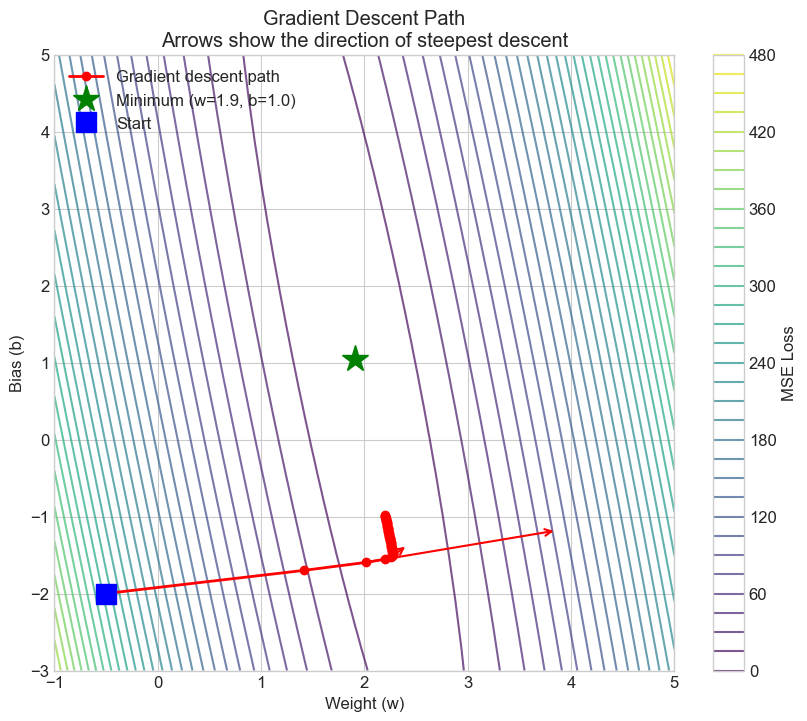

Started at:  w=-0.50, b=-2.00, loss=279.07
Ended at:    w=2.20, b=-0.98, loss=4.44
Minimum at:  w=1.91, b=1.04


In [ ]:
# Gradient descent on our simple loss surface
def loss_fn(w, b):
    y_pred = w * X_simple + b
    return np.mean((y_simple - y_pred) ** 2)

def gradient_fn(w, b):
    y_pred = w * X_simple + b
    residual = y_pred - y_simple
    dw = 2 * np.mean(residual * X_simple)
    db = 2 * np.mean(residual)
    return dw, db

# Run gradient descent from a bad starting point
w, b = -0.5, -2.0
lr = 0.01
path = [(w, b, loss_fn(w, b))]

for _ in range(50):
    dw, db = gradient_fn(w, b)
    w = w - lr * dw
    b = b - lr * db
    path.append((w, b, loss_fn(w, b)))

path = np.array(path)

# Plot the path on the contour
plt.figure(figsize=(10, 8))
plt.contour(W, B, Loss, levels=30, cmap='viridis', alpha=0.7)
plt.colorbar(label='MSE Loss')

# Plot path
plt.plot(path[:, 0], path[:, 1], 'ro-', markersize=6, linewidth=2, label='Gradient descent path')
plt.plot(w_min, b_min, 'g*', markersize=20, label=f'Minimum (w={w_min:.1f}, b={b_min:.1f})')
plt.plot(path[0, 0], path[0, 1], 'bs', markersize=15, label='Start')

# Draw gradient arrows for a few steps
for i in range(0, min(15, len(path)-1), 2):
    w_i, b_i = path[i, 0], path[i, 1]
    dw, db = gradient_fn(w_i, b_i)
    arrow_scale = 0.1
    plt.annotate('', xy=(w_i - arrow_scale*dw, b_i - arrow_scale*db),
                 xytext=(w_i, b_i),
                 arrowprops=dict(arrowstyle='->', color='red', lw=1.5))

plt.xlabel('Weight (w)')
plt.ylabel('Bias (b)')
plt.title('Gradient Descent Path\nArrows show the direction of steepest descent')
plt.legend(loc='upper left')
plt.show()

print(f"Started at:  w={path[0,0]:.2f}, b={path[0,1]:.2f}, loss={path[0,2]:.2f}")
print(f"Ended at:    w={path[-1,0]:.2f}, b={path[-1,1]:.2f}, loss={path[-1,2]:.2f}")
print(f"Minimum at:  w={w_min:.2f}, b={b_min:.2f}")

### Learning Rate — How Big Are Your Steps?

The learning rate $\eta$ is the most important hyperparameter. Too small and you'll crawl; too large and you'll overshoot.

| Learning Rate | Behavior |
|--------------|----------|
| Too small (0.001) | Very slow convergence |
| Just right (0.01) | Steady progress |
| A bit large (0.025) | Fast but may oscillate |
| Too large (0.05+) | Diverges! |

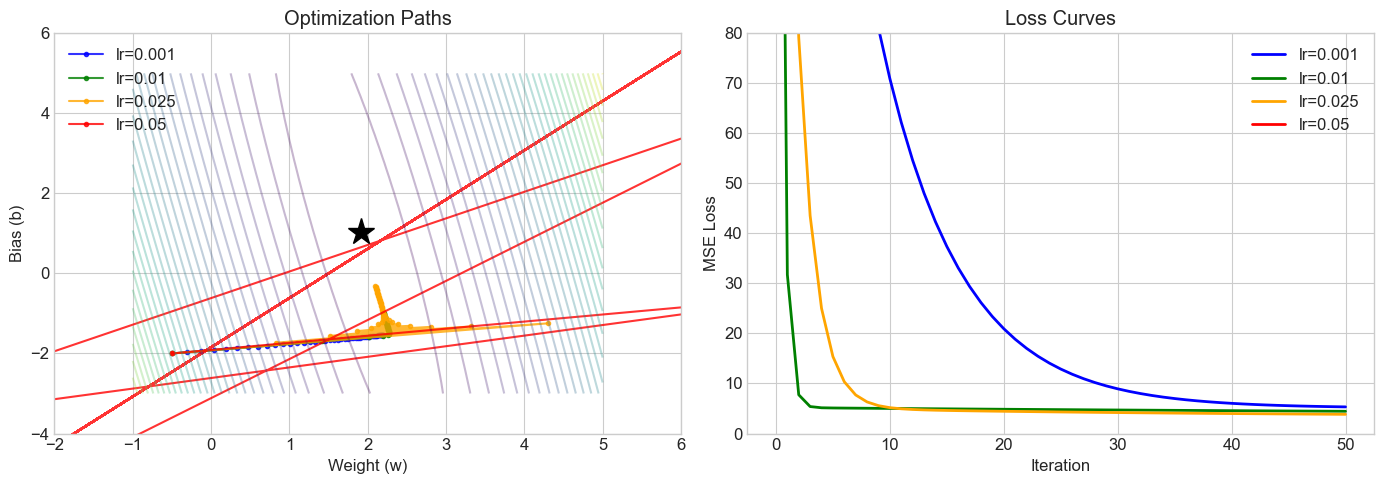

Observations:
  lr=0.001: Too slow — barely moves in 50 steps
  lr=0.01:  Good — steady convergence
  lr=0.025: Faster but oscillates near the minimum
  lr=0.05:  Overshoots and diverges!


In [ ]:
# Compare different learning rates
learning_rates = [0.001, 0.01, 0.025, 0.05]
colors = ['blue', 'green', 'orange', 'red']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for lr, color in zip(learning_rates, colors):
    w, b = -0.5, -2.0
    history = [(w, b)]
    losses = [loss_fn(w, b)]

    for _ in range(50):
        dw, db = gradient_fn(w, b)
        w = w - lr * dw
        b = b - lr * db
        history.append((w, b))
        losses.append(loss_fn(w, b))

    hist = np.array(history)

    # Paths on contour (clip for visualization only)
    hist_clipped = np.clip(hist, [-5, -8], [8, 8])
    axes[0].plot(hist_clipped[:, 0], hist_clipped[:, 1], 'o-', color=color, markersize=3,
                 linewidth=1.5, label=f'lr={lr}', alpha=0.8)

    # Loss curves
    axes[1].plot(losses, color=color, linewidth=2, label=f'lr={lr}')

axes[0].contour(W, B, Loss, levels=30, cmap='viridis', alpha=0.3)
axes[0].plot(w_min, b_min, 'k*', markersize=20)
axes[0].set_xlabel('Weight (w)')
axes[0].set_ylabel('Bias (b)')
axes[0].set_title('Optimization Paths')
axes[0].legend()
axes[0].set_xlim(-2, 6)
axes[0].set_ylim(-4, 6)

axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('MSE Loss')
axes[1].set_title('Loss Curves')
axes[1].legend()
axes[1].set_ylim(0, 80)

plt.tight_layout()
plt.show()

print("Observations:")
print("  lr=0.001: Too slow — barely moves in 50 steps")
print("  lr=0.01:  Good — steady convergence")
print("  lr=0.025: Faster but oscillates near the minimum")
print("  lr=0.05:  Overshoots and diverges!")

### Backpropagation — How PyTorch Computes Gradients

In Module 1, we wrote `loss.backward()`. This triggered **backpropagation** — an algorithm that uses the **chain rule** to compute how much each parameter contributed to the loss.

Let's trace through a simple example:

```
Forward:  y = w·x + b = 3·2 + 1 = 7
Loss:     L = (y - target)² = (7 - 5)² = 4

Backward (chain rule):
  dL/dy = 2(y - target) = 2(7-5) = 4
  dL/dw = dL/dy · dy/dw = 4 · x = 4 · 2 = 8
  dL/db = dL/dy · dy/db = 4 · 1 = 4
```

Let's verify this with PyTorch's autograd!

In [ ]:
# PyTorch autograd — automatic differentiation!

# Create tensors with gradient tracking
x = torch.tensor([2.0], requires_grad=True)
w = torch.tensor([3.0], requires_grad=True)
b = torch.tensor([1.0], requires_grad=True)

# Forward pass: y = w*x + b
y = w * x + b
target = torch.tensor([5.0])
loss = (y - target) ** 2

print("Forward pass:")
print(f"  y = w*x + b = {w.item()}*{x.item()} + {b.item()} = {y.item()}")
print(f"  loss = (y - target)² = ({y.item()} - {target.item()})² = {loss.item()}")

# Backward pass — PyTorch computes ALL gradients automatically!
loss.backward()

print(f"\nPyTorch autograd gradients:")
print(f"  dL/dw = {w.grad.item()}")
print(f"  dL/db = {b.grad.item()}")
print(f"  dL/dx = {x.grad.item()}")

print(f"\nManual verification (chain rule):")
print(f"  dL/dy = 2(y - target) = 2({y.item()} - {target.item()}) = {2*(y.item() - target.item())}")
print(f"  dL/dw = dL/dy · x = {2*(y.item() - target.item())} · {x.item()} = {2*(y.item() - target.item()) * x.item()}")
print(f"  dL/db = dL/dy · 1 = {2*(y.item() - target.item())}")
print(f"\nThey match! PyTorch autograd handles the chain rule for us.")

Forward pass:
  y = w*x + b = 3.0*2.0 + 1.0 = 7.0
  loss = (y - target)² = (7.0 - 5.0)² = 4.0

PyTorch autograd gradients:
  dL/dw = 8.0
  dL/db = 4.0
  dL/dx = 12.0

Manual verification (chain rule):
  dL/dy = 2(y - target) = 2(7.0 - 5.0) = 4.0
  dL/dw = dL/dy · x = 4.0 · 2.0 = 8.0
  dL/db = dL/dy · 1 = 4.0

They match! PyTorch autograd handles the chain rule for us.


### Gradient Flow in Multi-Layer Networks

In our perceptron, gradients only had to flow through one layer. But deeper networks have many layers, and gradients must flow through all of them via the chain rule:

$$\frac{\partial L}{\partial w_1} = \frac{\partial L}{\partial y} \cdot \frac{\partial y}{\partial h_2} \cdot \frac{\partial h_2}{\partial h_1} \cdot \frac{\partial h_1}{\partial w_1}$$

Each multiplication can shrink or grow the gradient. Let's see what happens.

In [ ]:
# Trace gradients through a 2-layer network
torch.manual_seed(42)

# Build a simple 2-layer network manually
w1 = torch.randn(4, 2, requires_grad=True)  # Layer 1: 2 → 4
b1 = torch.zeros(4, requires_grad=True)
w2 = torch.randn(1, 4, requires_grad=True)  # Layer 2: 4 → 1
b2 = torch.zeros(1, requires_grad=True)

# Forward pass (using Sigmoid to show gradient shrinkage)
x_demo = torch.tensor([[1.0, 2.0]])
h1 = x_demo @ w1.T + b1        # Hidden layer
h1_act = torch.sigmoid(h1)      # Sigmoid activation squashes to (0, 1)
output = h1_act @ w2.T + b2     # Output
loss = (output - torch.tensor([[3.0]])) ** 2

# Backward pass
loss.backward()

print("Forward pass:")
print(f"  Input:   {x_demo.data.numpy()}")
print(f"  Hidden:  {h1.data.numpy()}")
print(f"  After Sigmoid: {h1_act.data.numpy()}")
print(f"  Output:  {output.item():.4f}")
print(f"  Loss:    {loss.item():.4f}")

print(f"\nGradient magnitudes at each layer:")
print(f"  Layer 2 (w2): {w2.grad.abs().mean().item():.4f}")
print(f"  Layer 1 (w1): {w1.grad.abs().mean().item():.4f}")
print(f"\nNotice: Layer 1 gradients are smaller than Layer 2 gradients.")
print(f"Sigmoid squashes gradients as they flow backward through layers.")

Forward pass:
  Input:   [[1. 2.]]
  Hidden:  [[ 0.5943092   0.69512844 -1.495513    0.93220735]]
  After Sigmoid: [[0.6443532  0.6671068  0.18309571 0.71752286]]
  Output:  1.1545
  Loss:    3.4059

Gradient magnitudes at each layer:
  Layer 2 (w2): 2.0412
  Layer 1 (w1): 0.5664

Notice: Layer 1 gradients are smaller than Layer 2 gradients.
Sigmoid squashes gradients as they flow backward through layers.


### The Vanishing Gradient Problem

Here's a critical insight: when gradients flow backward through many layers, they get **multiplied** at each step. If those multipliers are less than 1 (as with the Sigmoid function), gradients shrink exponentially.

**Sigmoid**: $\sigma(x) = \frac{1}{1+e^{-x}}$

The maximum value of Sigmoid's derivative is only **0.25**. After just 5 layers:
$0.25^5 = 0.001$ — the gradient is nearly zero!

This is why deep networks with Sigmoid activations are hard to train — and why **ReLU** was a breakthrough (we'll see this in Notebook 2).

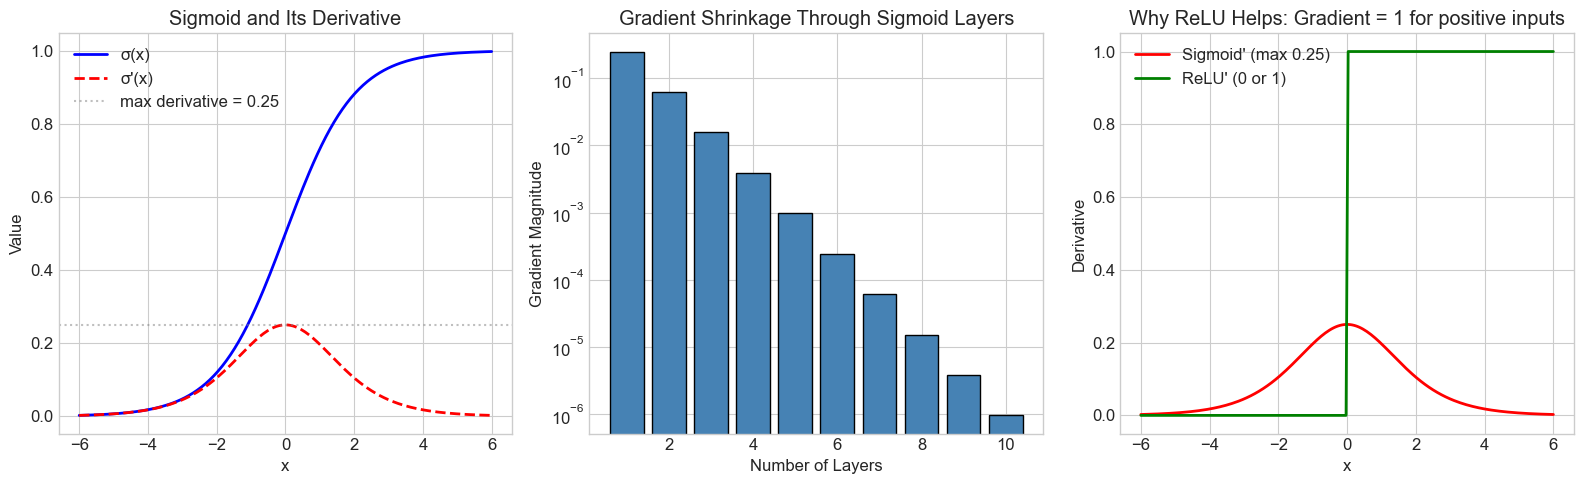

Key insight: Sigmoid squeezes gradients toward zero at every layer.
ReLU passes gradients through unchanged (for positive inputs).
This is why modern networks use ReLU — we'll explore this in Notebook 2!


In [ ]:
# Visualize sigmoid saturation and gradient shrinkage

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Sigmoid function
x = np.linspace(-6, 6, 200)
sigmoid = 1 / (1 + np.exp(-x))
sigmoid_deriv = sigmoid * (1 - sigmoid)

axes[0].plot(x, sigmoid, 'b-', linewidth=2, label='σ(x)')
axes[0].plot(x, sigmoid_deriv, 'r--', linewidth=2, label="σ'(x)")
axes[0].axhline(y=0.25, color='gray', linestyle=':', alpha=0.5, label='max derivative = 0.25')
axes[0].set_xlabel('x')
axes[0].set_ylabel('Value')
axes[0].set_title('Sigmoid and Its Derivative')
axes[0].legend()

# Plot 2: Gradient magnitude through layers
n_layers = range(1, 11)
grad_magnitude = [0.25**n for n in n_layers]

axes[1].bar(n_layers, grad_magnitude, color='steelblue', edgecolor='black')
axes[1].set_xlabel('Number of Layers')
axes[1].set_ylabel('Gradient Magnitude')
axes[1].set_title('Gradient Shrinkage Through Sigmoid Layers')
axes[1].set_yscale('log')

# Plot 3: Compare Sigmoid vs ReLU derivatives
relu = np.maximum(0, x)
relu_deriv = (x > 0).astype(float)

axes[2].plot(x, sigmoid_deriv, 'r-', linewidth=2, label="Sigmoid' (max 0.25)")
axes[2].plot(x, relu_deriv, 'g-', linewidth=2, label="ReLU' (0 or 1)")
axes[2].set_xlabel('x')
axes[2].set_ylabel('Derivative')
axes[2].set_title('Why ReLU Helps: Gradient = 1 for positive inputs')
axes[2].legend()

plt.tight_layout()
plt.show()

print("Key insight: Sigmoid squeezes gradients toward zero at every layer.")
print("ReLU passes gradients through unchanged (for positive inputs).")
print("This is why modern networks use ReLU — we'll explore this in Notebook 2!")

### Guided Exercise: Learning Rate on the Housing Model

Let's go back to our house price prediction model and see how learning rate affects it.

**Hypothesis**: Write down your predictions:
> *"With lr=0.0001, the model will _____ because _____."*
> *"With lr=1.0, the model will _____ because _____."*

**Experiment**: The cell below trains the housing perceptron with three different learning rates.

**Interpret**: Which learning rate works best? Does this match the patterns we saw on the simple loss surface?

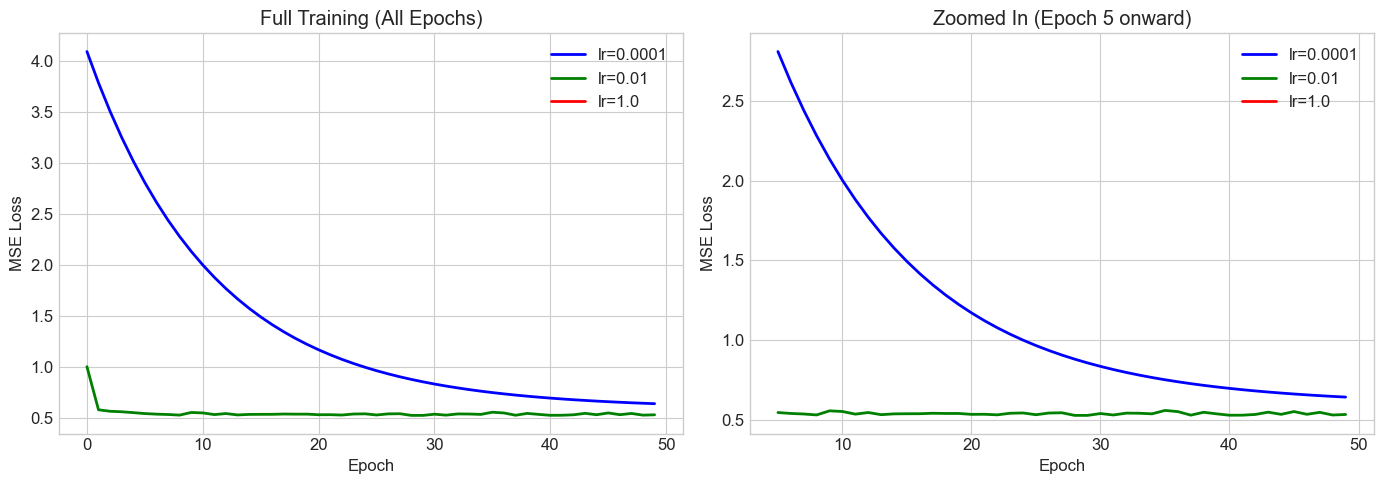

Results:
  lr=0.0001: Final loss = 0.6427
  lr=0.01: Final loss = 0.5337
  lr=1.0: Final loss = nan

Interpretation: The learning rate dramatically affects training!
Too small: slow convergence. Too large: may diverge or oscillate.
Just right: steady, fast progress toward the minimum.


In [ ]:
# EXPERIMENT: Learning rate comparison on our housing model
torch.manual_seed(42)

lr_results = {}
for lr in [0.0001, 0.01, 1.0]:
    torch.manual_seed(42)
    exp_model = Perceptron(input_size=8).to(device)
    exp_criterion = nn.MSELoss()
    exp_optimizer = optim.SGD(exp_model.parameters(), lr=lr)

    exp_losses = []
    for epoch in range(50):
        exp_model.train()
        epoch_loss = 0.0
        n = 0
        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)
            exp_optimizer.zero_grad()
            loss = exp_criterion(exp_model(features), targets)
            loss.backward()
            exp_optimizer.step()
            epoch_loss += loss.item() * features.size(0)
            n += features.size(0)
        exp_losses.append(epoch_loss / n)

    lr_results[lr] = exp_losses

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = {'0.0001': 'blue', '0.01': 'green', '1.0': 'red'}

for lr, losses in lr_results.items():
    c = colors[str(lr)]
    axes[0].plot(losses, color=c, linewidth=2, label=f'lr={lr}')
    # Zoomed version with correct x-axis
    axes[1].plot(range(5, 50), losses[5:], color=c, linewidth=2, label=f'lr={lr}')

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Full Training (All Epochs)')
axes[0].legend()

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MSE Loss')
axes[1].set_title('Zoomed In (Epoch 5 onward)')
axes[1].legend()

plt.tight_layout()
plt.show()

print("Results:")
for lr, losses in lr_results.items():
    print(f"  lr={lr}: Final loss = {losses[-1]:.4f}")
print(f"\nInterpretation: The learning rate dramatically affects training!")
print(f"Too small: slow convergence. Too large: may diverge or oscillate.")
print(f"Just right: steady, fast progress toward the minimum.")

### Module 2 Summary

Now you understand the mechanics behind neural network learning:

- **Loss surface**: The landscape defined by all possible parameter values — training seeks the minimum
- **Gradient descent**: Move in the direction of steepest descent on the loss surface
- **Learning rate**: Controls step size — too small is slow, too large diverges
- **Backpropagation**: Uses the chain rule to efficiently compute gradients through all layers
- **Vanishing gradients**: Sigmoid squeezes gradients exponentially — a key motivation for ReLU

**Coming up in Notebook 2**: Our perceptron is limited to linear relationships. What happens when we need to solve nonlinear problems? We'll discover *why* we need multiple layers and activation functions — and build networks that are much more powerful!